<a href="https://colab.research.google.com/github/snehachavhan2004/PRODIGY_ML_05/blob/main/PRODIGY_ML_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(tf.__version__)

2.17.1


In [23]:
# Define the dataset path
dataset_path = r'/content/drive/MyDrive/food-101-tiny'

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/food-101-tiny/valid/falafel/102356.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1104277.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1046752.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1202579.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1051179.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1070737.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1104779.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/102549.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1208661.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1099236.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1189019.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1541752.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1286955.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1298533.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/150112.jpg
/content/drive/MyDrive/food-101-tiny/valid/falafel/1238488

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Create a list with the filepaths for training and testing
train_dir = Path(os.path.join(dataset_path, 'train'))
train_filepaths = list(train_dir.glob(r'**/*.jpg'))


val_dir = Path(os.path.join(dataset_path, 'valid'))
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [25]:
def image_processing(filepath):
    """Create a DataFrame with the filepath and the labels of the pictures"""
    labels = []
    for file in filepath:
        parts = os.path.normpath(file).split(os.sep)
        if len(parts) > 1:
            labels.append(parts[-2])
        else:
            labels.append("Unknown")

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [26]:
train_df = image_processing(train_filepaths)
val_df = image_processing(val_filepaths)

In [27]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')


-- Training set --

Number of pictures: 1508

Number of different labels: 10

Labels: ['ice_cream' 'edamame' 'french_toast' 'ramen' 'tiramisu' 'cannoli' 'sushi'
 'apple_pie' 'falafel' 'bibimbap']


In [28]:
train_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/food-101-tiny/train/ice...,ice_cream
1,/content/drive/MyDrive/food-101-tiny/train/eda...,edamame
2,/content/drive/MyDrive/food-101-tiny/train/fre...,french_toast
3,/content/drive/MyDrive/food-101-tiny/train/ram...,ramen
4,/content/drive/MyDrive/food-101-tiny/train/tir...,tiramisu


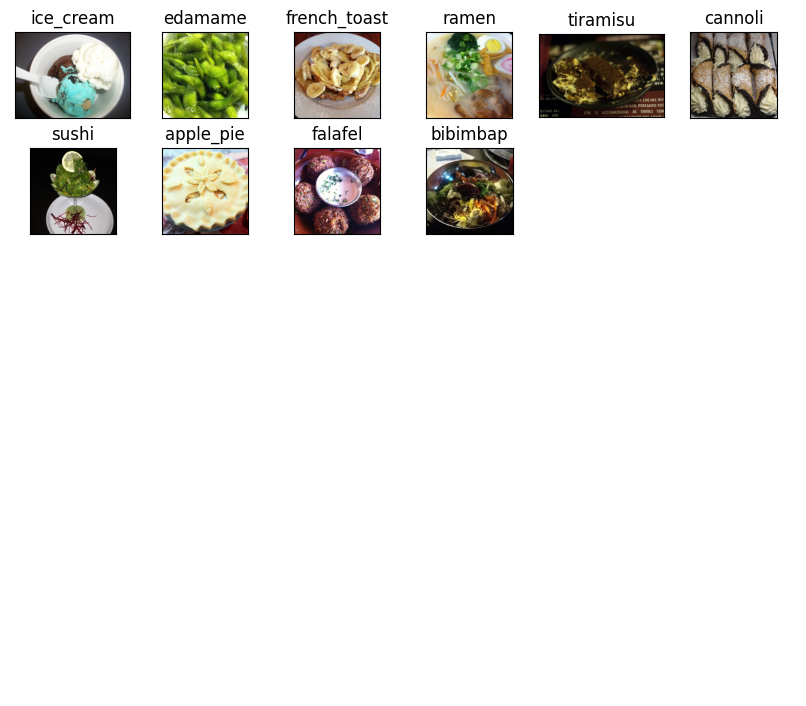

In [29]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(df_unique):
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)
    else:
        ax.axis('off')  # Turn off axis for empty subplots

plt.tight_layout(pad=0.5)
plt.show()

In [30]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [31]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 1508 validated image filenames belonging to 10 classes.


In [32]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 500 validated image filenames belonging to 10 classes.


In [33]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Get the number of classes from the training data
num_classes = len(train_images.class_indices)

outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 397s 7s/step - accuracy: 0.4095 - loss: 1.7600 - val_accuracy: 0.7080 - val_loss: 0.9193
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8046 - loss: 0.5764 - val_accuracy: 0.7620 - val_loss: 0.6704
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9008 - loss: 0.3245 - val_accuracy: 0.7840 - val_loss: 0.6310
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9578 - loss: 0.1856 - val_accuracy: 0.7700 - val_loss: 0.6918
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9632 - loss: 0.1342 - val_accuracy: 0.7940 - val_loss: 0.6446


In [35]:
# Predict the label of the test_images
pred = model.predict(val_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


['cannoli',
 'apple_pie',
 'french_toast',
 'falafel',
 'cannoli',
 'falafel',
 'bibimbap',
 'falafel',
 'edamame',
 'french_toast',
 'cannoli',
 'falafel',
 'apple_pie',
 'cannoli',
 'edamame',
 'edamame',
 'tiramisu',
 'bibimbap',
 'ramen',
 'tiramisu',
 'apple_pie',
 'french_toast',
 'cannoli',
 'ice_cream',
 'french_toast',
 'ice_cream',
 'falafel',
 'cannoli',
 'ice_cream',
 'bibimbap',
 'bibimbap',
 'falafel',
 'tiramisu',
 'french_toast',
 'tiramisu',
 'edamame',
 'french_toast',
 'edamame',
 'falafel',
 'sushi',
 'cannoli',
 'sushi',
 'cannoli',
 'bibimbap',
 'cannoli',
 'apple_pie',
 'bibimbap',
 'cannoli',
 'edamame',
 'falafel',
 'ice_cream',
 'bibimbap',
 'apple_pie',
 'ice_cream',
 'ramen',
 'french_toast',
 'ramen',
 'tiramisu',
 'sushi',
 'bibimbap',
 'french_toast',
 'bibimbap',
 'tiramisu',
 'edamame',
 'apple_pie',
 'edamame',
 'edamame',
 'french_toast',
 'french_toast',
 'falafel',
 'tiramisu',
 'cannoli',
 'french_toast',
 'cannoli',
 'bibimbap',
 'french_toast',
 

In [38]:
import pandas as pd
import plotly.express as px

# Assuming 'history' is your Keras training history object
loss_data = pd.DataFrame({
    'Epoch': range(1, len(history.history['loss']) + 1),
    'Training Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
})

# Melt the DataFrame for better visualization
loss_data_melted = loss_data.melt(id_vars='Epoch', var_name='Type', value_name='Loss')

# Plot with Plotly Express
fig = px.line(
    loss_data_melted,
    x='Epoch',
    y='Loss',
    color='Type',
    title='Model Loss',
    labels={'Loss': 'Loss', 'Epoch': 'Epoch'}
)
fig.show()


In [39]:
import pandas as pd
import plotly.express as px

# Assuming 'history' is your Keras training history object
accuracy_data = pd.DataFrame({
    'Epoch': range(1, len(history.history['accuracy']) + 1),
    'Training Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy']
})

# Melt the DataFrame for better visualization
accuracy_data_melted = accuracy_data.melt(id_vars='Epoch', var_name='Type', value_name='Accuracy')

# Plot with Plotly Express
fig = px.line(
    accuracy_data_melted,
    x='Epoch',
    y='Accuracy',
    color='Type',
    title='Model Accuracy',
    labels={'Accuracy': 'Accuracy', 'Epoch': 'Epoch'}
)
fig.show()


In [40]:
def output(location):
    img = load_img(location, target_size=(224, 224, 3))
    img_array = img_to_array(img)
    img_array = img_array / 255
    img_array = np.expand_dims(img_array, [0])
    answer = model.predict(img_array)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]


    calorie_estimates = {
        'apple_pie': 237,
        'bibimbap': 560,
        'cannoli': 230,
        'edamame': 122,
        'falafel': 333,
        'french_toast': 229,
        'ice_cream': 207,
        'ramen': 380,
        'sushi': 300,
        'tiramisu': 240
    }
    estimated_calories = calorie_estimates.get(res, "Unknown")

    # Plot the predicted image with calorie estimation
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'Predicted: {res}\nEstimated Calories: {estimated_calories}')
    plt.axis('off')
    plt.show()

    return res, estimated_calories

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


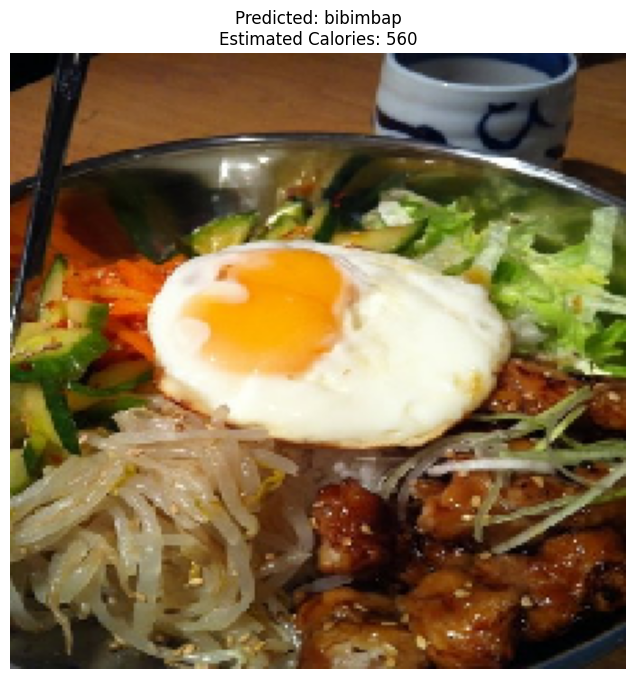

In [41]:
img = output(r'/content/drive/MyDrive/food-101-tiny/valid/bibimbap/1007274.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


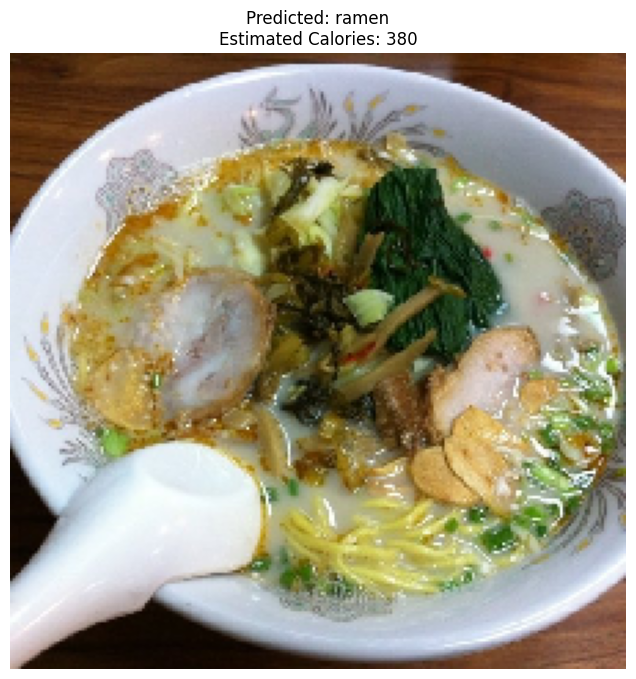

In [42]:
img = output(r'/content/drive/MyDrive/food-101-tiny/valid/ramen/1032031.jpg')